In [1]:
import json

import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm

tqdm.pandas()

### 1. Leer el conjunto de datos descargados

In [2]:
collected_data = pd.read_json('./all_collected_data.jsonl', lines=True)
print(f"Columnas: {list(collected_data.columns)}\nNúmero de Filas: {len(collected_data)}")
collected_data.head()

Columnas: ['community_page', 'document_page', 'breadcrumb', 'file_urls', 'files']
Número de Filas: 26837


,community_page,document_page,breadcrumb,file_urls,files
0,https://repositorio.umsa.bo/handle/123456789/1...,https://repositorio.umsa.bo/handle/123456789/3...,"[DSpace Home, Área Vicerrectorado, Biblioteca ...",[https://repositorio.umsa.bo/bitstream/handle/...,[{'url': 'https://repositorio.umsa.bo/bitstrea...
1,https://repositorio.umsa.bo/handle/123456789/1...,https://repositorio.umsa.bo/handle/123456789/3...,"[DSpace Home, Área Vicerrectorado, Biblioteca ...",[https://repositorio.umsa.bo/bitstream/handle/...,[{'url': 'https://repositorio.umsa.bo/bitstrea...
2,https://repositorio.umsa.bo/handle/123456789/1...,https://repositorio.umsa.bo/handle/123456789/3...,"[DSpace Home, Área Vicerrectorado, Biblioteca ...",[https://repositorio.umsa.bo/bitstream/handle/...,[{'url': 'https://repositorio.umsa.bo/bitstrea...
3,https://repositorio.umsa.bo/handle/123456789/3...,https://repositorio.umsa.bo/handle/123456789/3...,"[DSpace Home, Facultad de Tecnología, Carrera ...",[https://repositorio.umsa.bo/bitstream/handle/...,[{'url': 'https://repositorio.umsa.bo/bitstrea...
4,https://repositorio.umsa.bo/handle/123456789/3...,https://repositorio.umsa.bo/handle/123456789/3...,"[DSpace Home, Facultad de Tecnología, Carrera ...",[https://repositorio.umsa.bo/bitstream/handle/...,[{'url': 'https://repositorio.umsa.bo/bitstrea...


### 2. Solo conservar los datos donde de descargaron ambos archivos, el XML y el PDF

In [3]:
collected_data = collected_data[collected_data['files'].str.len() == 2]
print(f"Número de Filas: {len(collected_data)}")

Número de Filas: 26826


### 3. Desempaquetar algunos campos desde el `breadcrumb` y `xml_content` los cuales serán útiles para analizar el conjunto de datos y determinar que datos incluir y excluir

In [4]:
collected_data['pdf_path'] = collected_data['files'].str[0].str['path']
collected_data['xml_path'] = collected_data['files'].str[1].str['path']

In [5]:
from parsel import Selector
import codecs

def read_file(filename):
    with codecs.open(filename, 'r', 'utf-8') as f:
        return f.read()
    
def get_field(xml_string: str, attribute, value, return_all_matches=False):
    sel = Selector(text=xml_string)
    sel.register_namespace('dim', 'http://www.dspace.org/xmlns/dspace/dim')
    matches = sel.xpath(f'//dim/field[@{attribute}="{value}"]/text()')
    if return_all_matches:
        return matches.getall()
    return matches.get()

def get_advisors(xml_string):
    return get_field(xml_string, 'qualifier', 'advisor', return_all_matches=True)

def get_authors(xml_string):
    return get_field(xml_string, 'qualifier', 'author', return_all_matches=True)

def get_issued(xml_string):
    return get_field(xml_string, 'qualifier', 'issued')

def get_abstract(xml_string):
    return get_field(xml_string, 'qualifier', 'abstract')

def get_subjects(xml_string):
    return get_field(xml_string, 'element', 'subject', return_all_matches=True)

def get_uri(xml_string):
    return get_field(xml_string, 'qualifier', 'uri')

def get_title(xml_string):
    return  get_field(xml_string, 'element', 'title')

collected_data['xml_content'] = collected_data['xml_path'].progress_map(lambda xml_path: read_file('files/' + xml_path), na_action='ignore')

collected_data['advisors'] = collected_data['xml_content'].progress_map(get_advisors, na_action='ignore')
collected_data['authors'] = collected_data['xml_content'].progress_map(get_authors, na_action='ignore')
collected_data['issued'] = collected_data['xml_content'].progress_map(get_issued, na_action='ignore')
collected_data['abstract'] = collected_data['xml_content'].progress_map(get_abstract, na_action='ignore')
collected_data['subjects'] = collected_data['xml_content'].progress_map(get_subjects, na_action='ignore')
collected_data['title'] = collected_data['xml_content'].progress_map(get_title, na_action='ignore')

100%|██████████| 26826/26826 [00:04<00:00, 6006.42it/s]


In [6]:
collected_data['doc_type'] = collected_data['breadcrumb'].str[-2]
collected_data['faculty'] = collected_data['breadcrumb'].str[1]
collected_data['department'] = collected_data['breadcrumb'].str[2]

In [7]:
collected_data.head()

,community_page,document_page,breadcrumb,file_urls,files,pdf_path,xml_path,xml_content,advisors,authors,issued,abstract,subjects,title,doc_type,faculty,department
0,https://repositorio.umsa.bo/handle/123456789/1...,https://repositorio.umsa.bo/handle/123456789/3...,"[DSpace Home, Área Vicerrectorado, Biblioteca ...",[https://repositorio.umsa.bo/bitstream/handle/...,[{'url': 'https://repositorio.umsa.bo/bitstrea...,full/24d6bf95ecb69df11c502e3861e22a68444d450b,full/75dd4feb9da28bdd526748086322b5da9f222b15.xml,"<?xml version=""1.0"" encoding=""UTF-8""?><mets:ME...",[],[Bolivia. Contraloría General.],1931,Relación desglosada de los ingresos del Presu...,[PRESUPUESTO NACIONAL 1931],Cálculo de las entradas ordinarias relativas a...,Folletería,Área Vicerrectorado,Biblioteca Universitaria Central
1,https://repositorio.umsa.bo/handle/123456789/1...,https://repositorio.umsa.bo/handle/123456789/3...,"[DSpace Home, Área Vicerrectorado, Biblioteca ...",[https://repositorio.umsa.bo/bitstream/handle/...,[{'url': 'https://repositorio.umsa.bo/bitstrea...,full/9eb9bbd46a316ef18195e736d0f17763bacfe176,full/608914fb37e2fe3de496665b8a8acea61f9892f8.xml,"<?xml version=""1.0"" encoding=""UTF-8""?><mets:ME...",[],"[Loza, Manuel León]",1932,Defensa en los estrados judiciales del Gral. J...,"[JUICIO DE RESPONSABILIDAD, CONTRATOS VICKERS]",Defensa del general José C. Quiroz en la acusa...,Folletería,Área Vicerrectorado,Biblioteca Universitaria Central
2,https://repositorio.umsa.bo/handle/123456789/1...,https://repositorio.umsa.bo/handle/123456789/3...,"[DSpace Home, Área Vicerrectorado, Biblioteca ...",[https://repositorio.umsa.bo/bitstream/handle/...,[{'url': 'https://repositorio.umsa.bo/bitstrea...,full/26a953b0d5f432075eefa0513bc0df9dcf78f955,full/ebf14ea9c92e1833ebfb3ad9db25c5bd2edfc9c6.xml,"<?xml version=""1.0"" encoding=""UTF-8""?><mets:ME...",[],[Bolivia. Ministerio de Hacienda Oficina Técnica],1929,Cálculo de las entradas ordinarias clasificada...,[PRESUPUESTOS DEPARTAMENTALES 1929],Cálculo de las entradas ordinarias y extraordi...,Folletería,Área Vicerrectorado,Biblioteca Universitaria Central
3,https://repositorio.umsa.bo/handle/123456789/3...,https://repositorio.umsa.bo/handle/123456789/3...,"[DSpace Home, Facultad de Tecnología, Carrera ...",[https://repositorio.umsa.bo/bitstream/handle/...,[{'url': 'https://repositorio.umsa.bo/bitstrea...,full/47857a7b53a89293af682bcac55a2cc8fb2d6b27,full/2f653a0aa9018032d8af6e179afe2cc21a5a03ef.xml,"<?xml version=""1.0"" encoding=""UTF-8""?><mets:ME...","[Marquez Gonzales, Luis Richard, tutor]","[Cuareti Condori, Nelson Lucio]",2022,Nuestro país se encuentra en vías de crecimien...,"[SISTEMA DE SEGURIDAD, TRANSMISIÓN DE DATOS, S...",Optimización del sistema de seguridad y etique...,Proyectos de Grado,Facultad de Tecnología,Carrera Electrónica y Telecomunicaciones
4,https://repositorio.umsa.bo/handle/123456789/3...,https://repositorio.umsa.bo/handle/123456789/3...,"[DSpace Home, Facultad de Tecnología, Carrera ...",[https://repositorio.umsa.bo/bitstream/handle/...,[{'url': 'https://repositorio.umsa.bo/bitstrea...,full/ded51872a52f6d1f1439621b41463e775eed6968,full/ad171ec41d677838d0914628b03f2e4c192f6d7a.xml,"<?xml version=""1.0"" encoding=""UTF-8""?><mets:ME...","[Marin Thames, José Arturo, tutor]","[Marquez Castro, Vannia Estephanie]",2021,Este documento trata de la manera de desarroll...,"[DETECTOR DE INCENDIOS, EMPRESA ROSVANIA, PREV...",Desarrollo de un sistema electrónico que permi...,Proyectos de Grado,Facultad de Tecnología,Carrera Electrónica y Telecomunicaciones


import xml.dom.minidom

text = collected_data['xml_content'].iloc[10001]
dom = xml.dom.minidom.parseString(text)
print(dom.toprettyxml())

### 4. Determinar los tipos de documentos a procesar

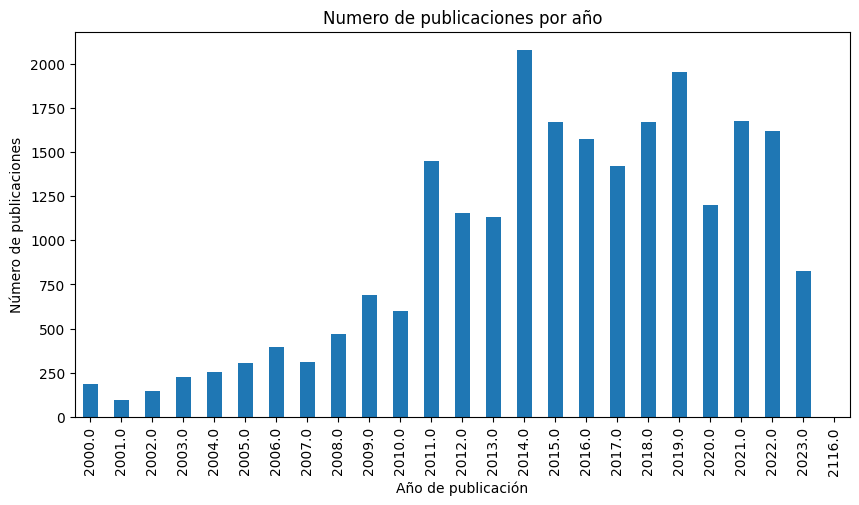

In [41]:
from matplotlib.ticker import FuncFormatter
import re
import matplotlib.pyplot as plt

def get_year(text: str):
    match = re.search(r'\d{4}', text)
    if match:
        return int(match[0])
    return 0

collected_data['year'] = collected_data['issued'].map(get_year, na_action='ignore')
grouped: pd.Series = collected_data[collected_data['year'] >= 2000].groupby('year').size()
# grouped.sort_values(ascending=True, inplace=True)

ax = grouped.plot(kind='bar', figsize=(10, 5))
ax.set_ylabel('Número de publicaciones')
ax.set_xlabel('Año de publicación')
# ax2 = ax.secondary_xaxis('top')
# ax2.set_xlabel('Número de publicaciones')

plt.title('Numero de publicaciones por año')
plt.show()

In [26]:
collected_data.groupby('doc_type').size()

doc_type
Artículos Científicos                                                            95
Boletín Kipus                                                                    19
Catálogos                                                                       202
Catálogos bibliográficos                                                          4
Colecciones Especiales                                                           30
                                                                               ... 
Trabajo Dirigido                                                                638
Trabajos Dirigidos                                                             3111
Trabajos de Investigación de Posdoctorado en Filosofía Ciencia y Tecnología       9
Trabajos dirigidos                                                              487
Untitled                                                                         29
Length: 88, dtype: int64

#### 4.1 Solo conservar documentos posteriores al 2010

In [10]:
collected_data = collected_data[collected_data['year'] >= 2010]
len(collected_data)

20031

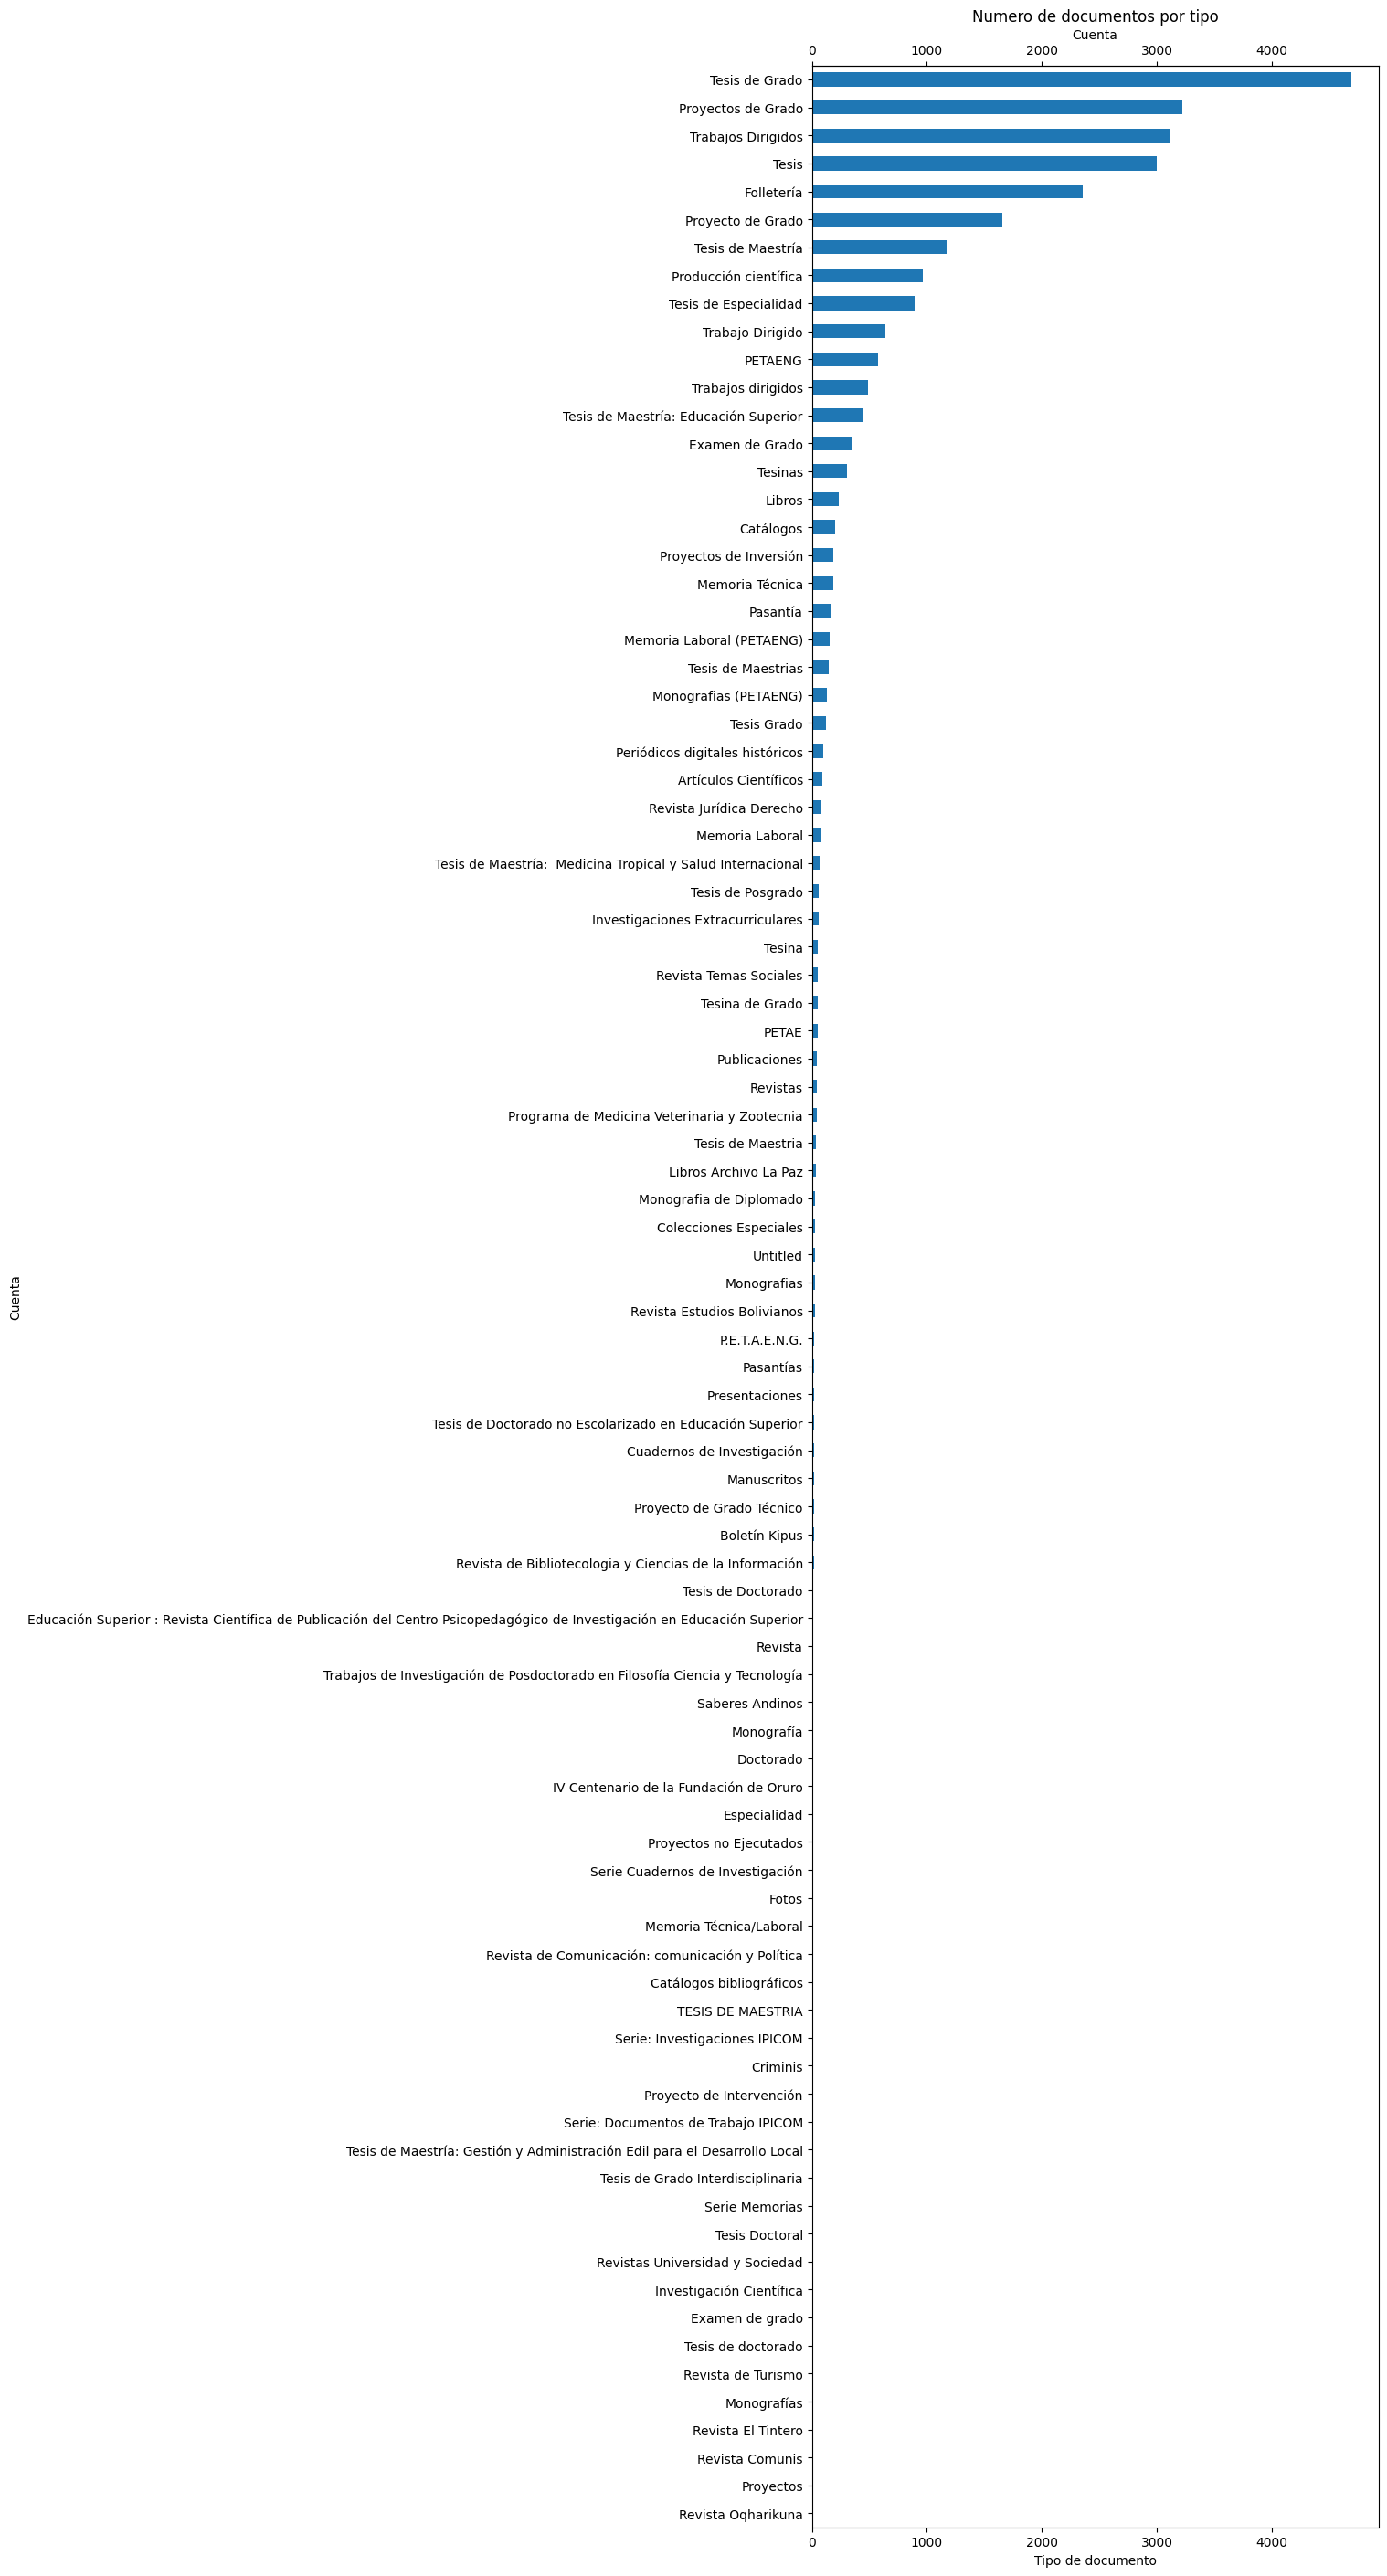

In [28]:
import matplotlib.pyplot as plt

grouped: pd.Series = collected_data.groupby('doc_type').size()
grouped.sort_values(ascending=True, inplace=True)

ax = grouped.plot(kind='barh', figsize=(8, 35))
ax.set_xlabel('Tipo de documento')
ax.set_ylabel('Cuenta')
ax2 = ax.secondary_xaxis('top')
ax2.set_xlabel('Cuenta')

plt.title('Numero de documentos por tipo')
plt.show()

/tmp/ipykernel_3320/3551659539.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


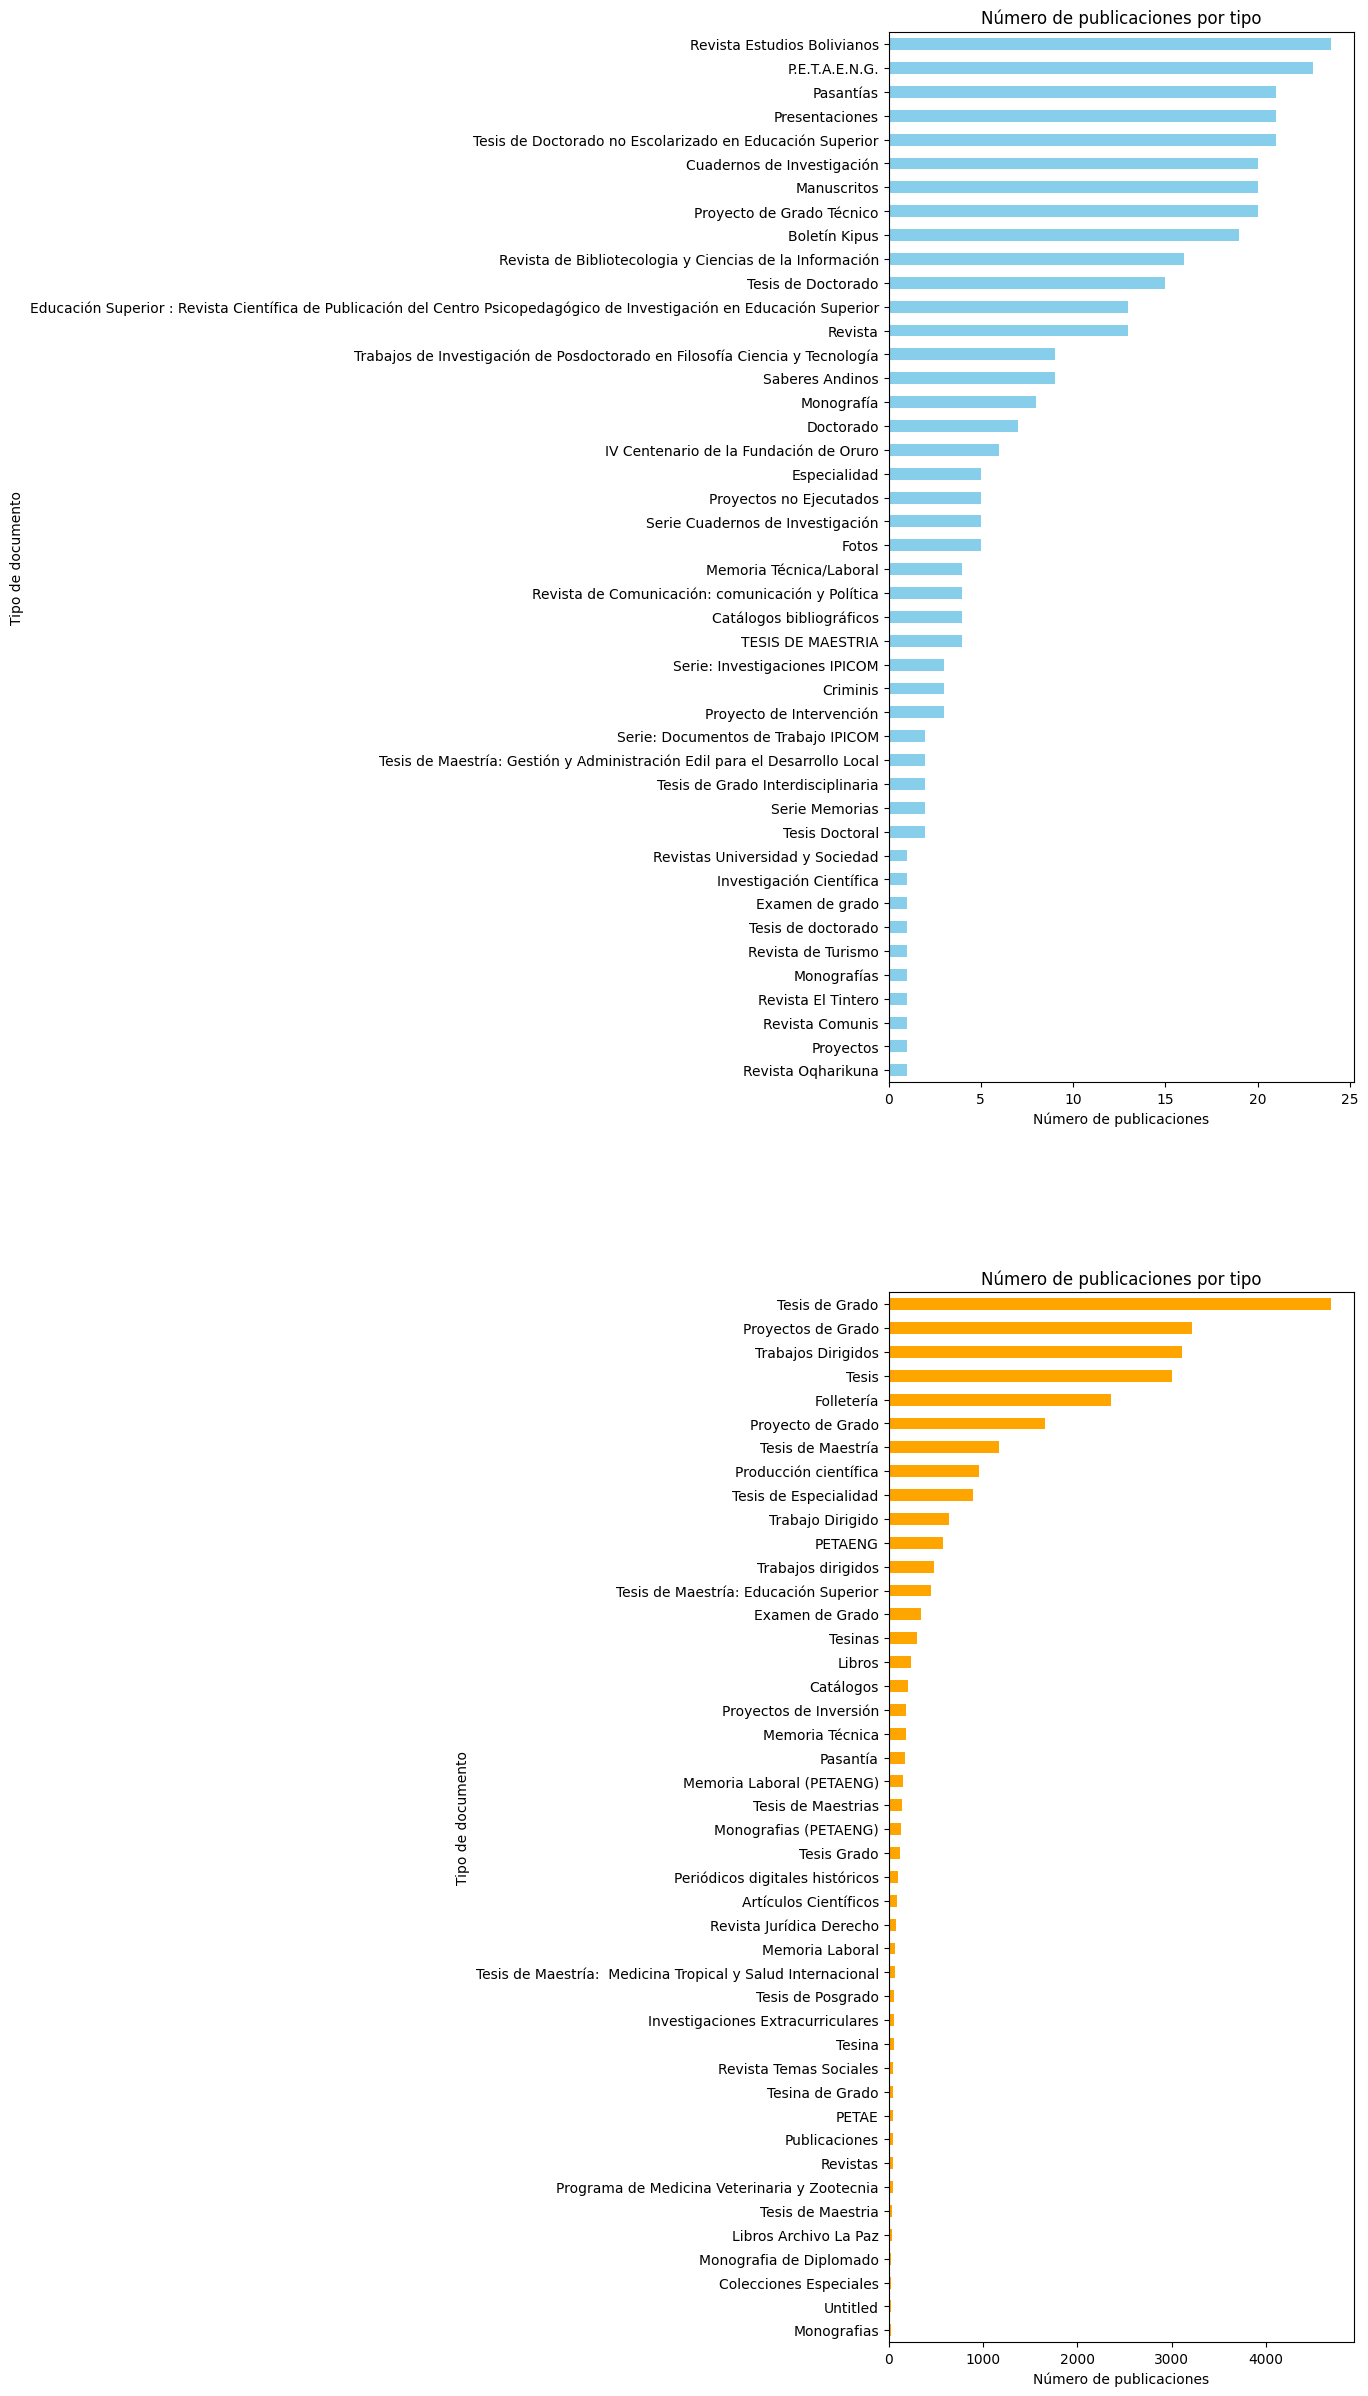

In [35]:
# Splitting the series into two halves
half_point = len(grouped) // 2
first_half = grouped[:half_point]
second_half = grouped[half_point:]

# Creating a figure and two subplots
fig, axs = plt.subplots(2, 1, figsize=(6, 30))

# Plotting first half in the first subplot
first_half.plot(kind='barh', color='skyblue', ax=axs[0])
axs[0].set_xlabel('Número de publicaciones')
axs[0].set_ylabel('Tipo de documento')
axs[0].set_title('Número de publicaciones por tipo')

# Plotting second half in the second subplot
second_half.plot(kind='barh', color='orange', ax=axs[1])
axs[1].set_xlabel('Número de publicaciones')
axs[1].set_ylabel('Tipo de documento')
axs[1].set_title('Número de publicaciones por tipo')

# Adjust layout to prevent overlapping titles
plt.tight_layout()
plt.show()

#### 4.2 Solo procesar ciertos tipos de documentos

In [12]:
import re

document_types_to_process = [
    'Proyectos de Grado',
    'Tesis de Grado',
    'Tesis',
    'Trabajo Dirigido',
    'Proyecto de Grado',
    'Tesis de Especialidad',
    'Tesis de Maestría',
    'Trabajos Dirigidos',
    'PETAENG',
    'Trabajos dirigidos'
]

documents_to_process = collected_data[collected_data['doc_type'].isin(document_types_to_process)]
print(f"Número de Filas: {len(documents_to_process)}")

Número de Filas: 16098


#### 4.3 Verificar que los tipos de documentos seleccionados tienen el formato esperado

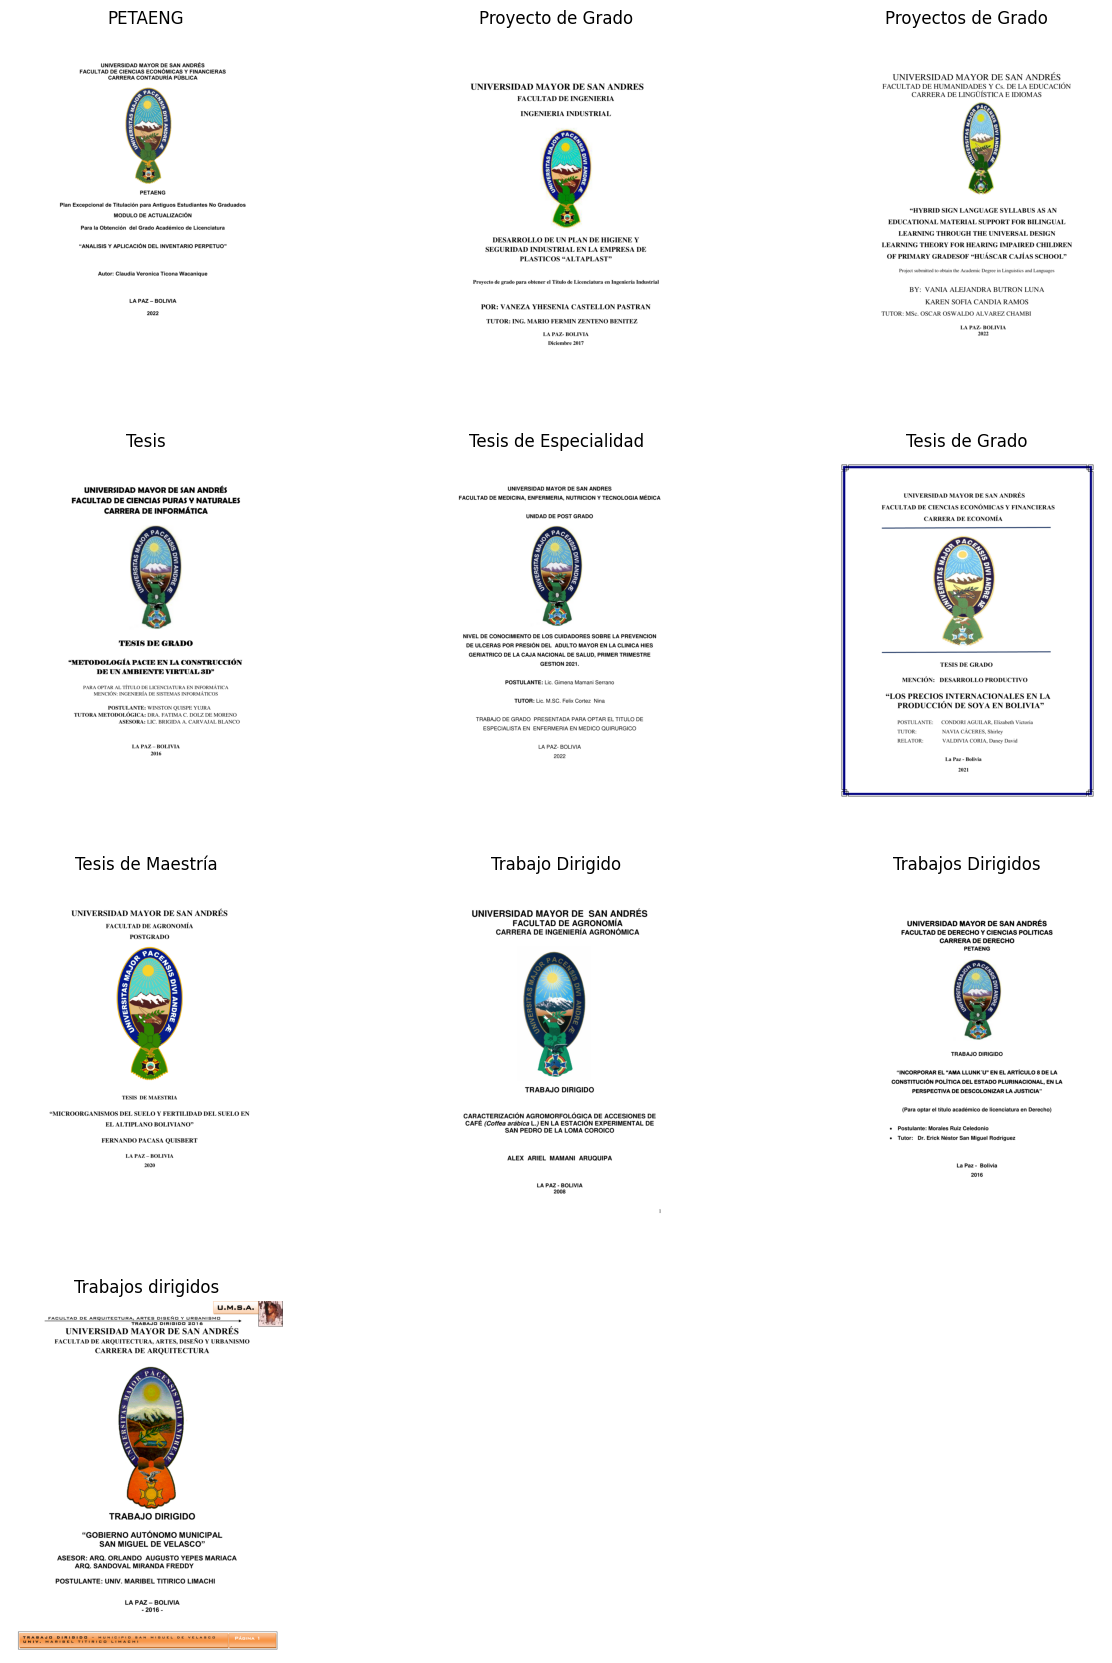

In [13]:
from pdf2image import convert_from_path
import matplotlib.pyplot as plt

def plot_cover_pages(pdfs: dict):   
    w = 10
    h = 10
    fig = plt.figure(figsize=(15, 65))
    columns = 3
    rows = 12
    i = 1
    for doc_type, pdf in pdfs.items():
        img = convert_from_path(f"files/{pdf}", first_page=0, last_page=1)[0]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(doc_type)
        i = i + 1
    plt.show()

plot_cover_pages(documents_to_process.groupby('doc_type').sample(1).set_index('doc_type')['pdf_path'].to_dict())  #.first()['pdf_path'].to_dict())

### 5. Estadísticas de los documentos a procesar 

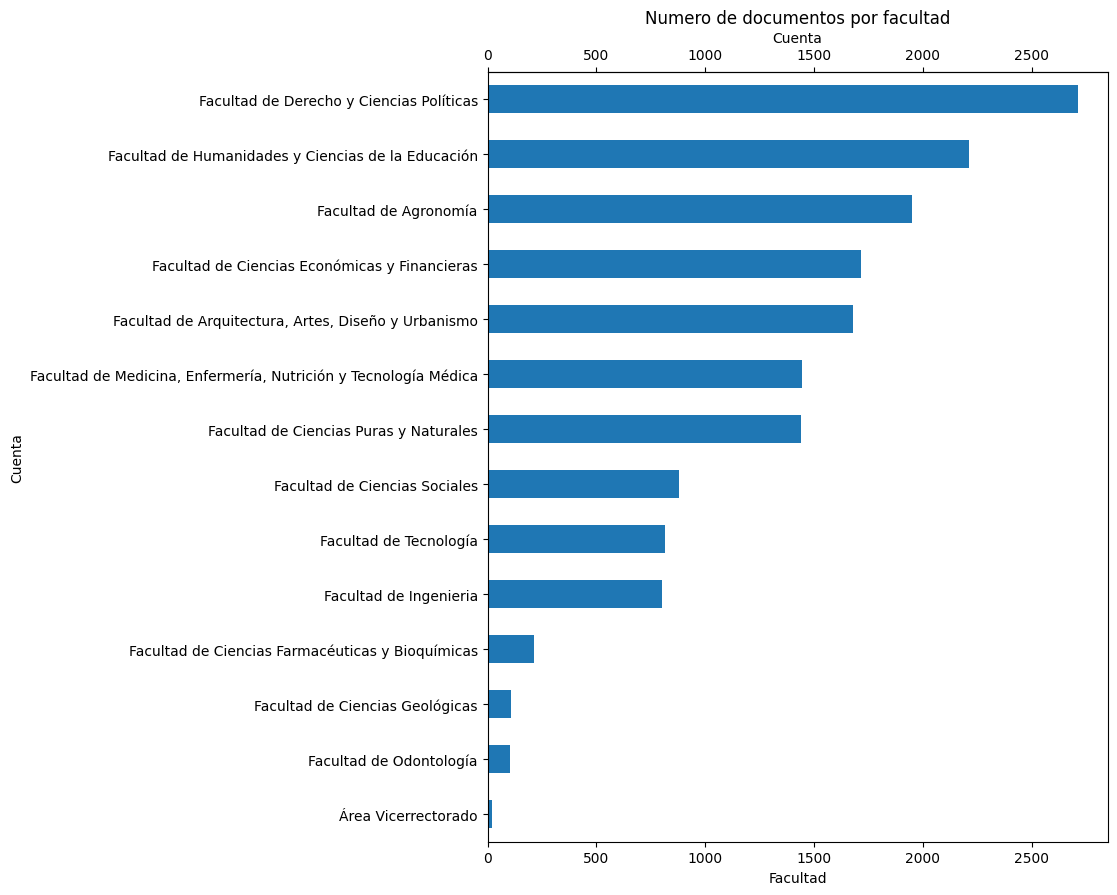

In [14]:
grouped: pd.Series = documents_to_process.groupby('faculty').size()
grouped.sort_values(ascending=True, inplace=True)

ax = grouped.plot(kind='barh', figsize=(8, 10))
ax.set_xlabel('Facultad')
ax.set_ylabel('Cuenta')
ax2 = ax.secondary_xaxis('top')
ax2.set_xlabel('Cuenta')

plt.title('Numero de documentos por facultad')
plt.show()

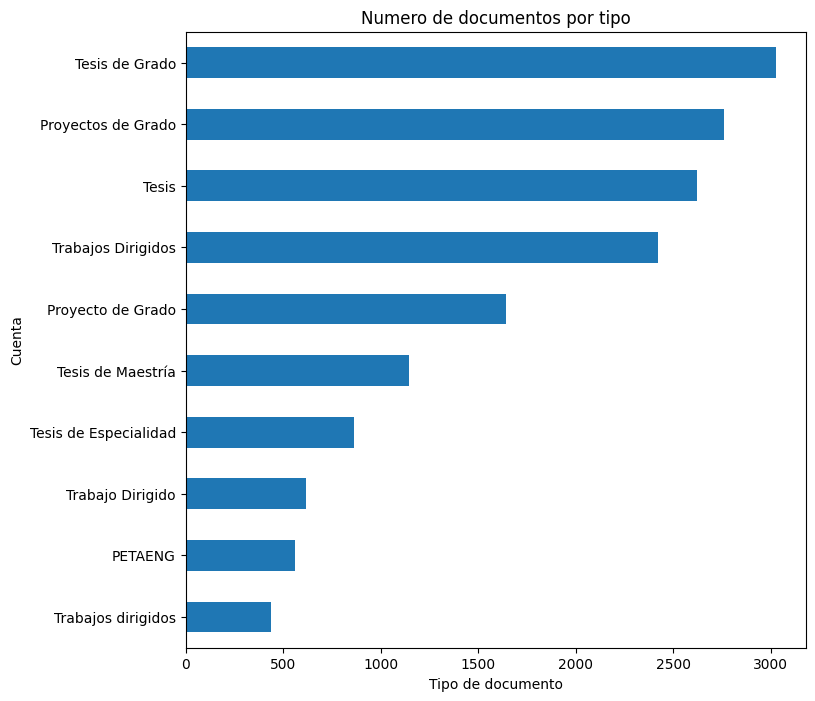

In [15]:
import matplotlib.pyplot as plt

grouped = documents_to_process.groupby('doc_type').size()
grouped.sort_values(ascending=True, inplace=True)
grouped.plot(kind='barh', figsize=(8,8))
plt.xlabel('Tipo de documento')
plt.ylabel('Cuenta')
plt.title('Numero de documentos por tipo')
plt.show()

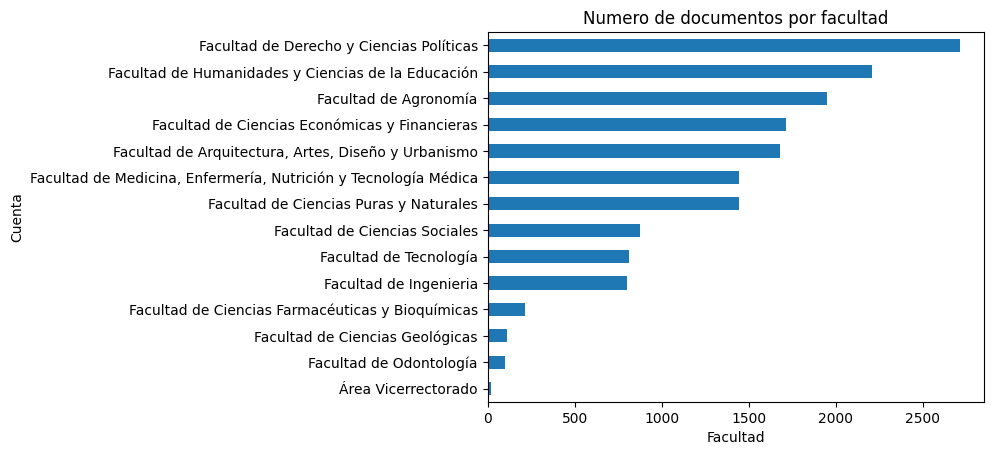

In [16]:
grouped = documents_to_process.groupby('faculty').size()
grouped.sort_values(ascending=True, inplace=True)
grouped.plot(kind='barh')
plt.xlabel('Facultad')
plt.ylabel('Cuenta')
plt.title('Numero de documentos por facultad')
plt.show()

pd.unique(documents_to_process['faculty'])

faculties_to_process = ['Facultad de Ingenieria']
documents_to_process = documents_to_process[documents_to_process['faculty'].isin(faculties_to_process)]
len(documents_to_process)

### 6. Leer con OCR la primera página de cada documento

Este paso es hecho al último ya que es computacionalmente costoso y conviene hacerlo una vez determinado el conjunto de datos con los que se trabajara en el entrenamiento del modelo

In [17]:
from utils import extract_cover_page_text
from concurrent.futures import ThreadPoolExecutor
import magic

def read_cover_page_from_pdf(filename):
    if magic.from_file(filename, mime=True) == 'application/pdf':
        try:
            return extract_cover_page_text(filename)
        except Exception as e:
            print(f"Error when processing {filename}", e)
            return np.nan
    return np.nan

# documents_to_process['pdf_cover_page'] = documents_to_process['pdf_path'].progress_map(lambda pdf_path: read_cover_page_from_pdf('files/' + pdf_path), na_action='ignore')

def process_pdf(pdf_path):
    return read_cover_page_from_pdf('files/' + pdf_path)

num_threads = 4
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    results = list(tqdm(executor.map(process_pdf, documents_to_process['pdf_path']), total=len(documents_to_process)))
documents_to_process['pdf_cover_page'] = results

 50%|█████     | 8127/16098 [23:40<18:40,  7.11it/s]   

Error when processing files/full/03c2675b16620bcdd81d5770751e9708b7f4b829 Unable to get page count.
Syntax Error: Couldn't find trailer dictionary
Syntax Error: Couldn't find trailer dictionary
Syntax Error: Couldn't read xref table


100%|██████████| 16098/16098 [44:45<00:00,  5.99it/s]  
/tmp/ipykernel_70775/1244473778.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents_to_process['pdf_cover_page'] = results


In [1]:
documents_to_process.to_pickle('cache_documents_to_process.pkl')

NameError: name 'documents_to_process' is not defined

In [19]:
documents_to_process.head()

,community_page,document_page,breadcrumb,file_urls,files,pdf_path,xml_path,xml_content,advisors,authors,issued,abstract,subjects,title,doc_type,faculty,year,pdf_cover_page
3,https://repositorio.umsa.bo/handle/123456789/3...,https://repositorio.umsa.bo/handle/123456789/3...,"[DSpace Home, Facultad de Tecnología, Carrera ...",[https://repositorio.umsa.bo/bitstream/handle/...,[{'url': 'https://repositorio.umsa.bo/bitstrea...,full/47857a7b53a89293af682bcac55a2cc8fb2d6b27,full/2f653a0aa9018032d8af6e179afe2cc21a5a03ef.xml,"<?xml version=""1.0"" encoding=""UTF-8""?><mets:ME...","Marquez Gonzales, Luis Richard, tutor","Cuareti Condori, Nelson Lucio",2022,Nuestro país se encuentra en vías de crecimien...,SISTEMA DE SEGURIDAD,Optimización del sistema de seguridad y etique...,Proyectos de Grado,Facultad de Tecnología,2022.0,UNIVERSIDAD MAYOR DE SAN ANDRES\n\nFACULTAD DE...
4,https://repositorio.umsa.bo/handle/123456789/3...,https://repositorio.umsa.bo/handle/123456789/3...,"[DSpace Home, Facultad de Tecnología, Carrera ...",[https://repositorio.umsa.bo/bitstream/handle/...,[{'url': 'https://repositorio.umsa.bo/bitstrea...,full/ded51872a52f6d1f1439621b41463e775eed6968,full/ad171ec41d677838d0914628b03f2e4c192f6d7a.xml,"<?xml version=""1.0"" encoding=""UTF-8""?><mets:ME...","Marin Thames, José Arturo, tutor","Marquez Castro, Vannia Estephanie",2021,Este documento trata de la manera de desarroll...,DETECTOR DE INCENDIOS,Desarrollo de un sistema electrónico que permi...,Proyectos de Grado,Facultad de Tecnología,2021.0,UNIVERSIDAD MAYOR DE SAN ANDRES\nFACULTAD DE T...
5,https://repositorio.umsa.bo/handle/123456789/3...,https://repositorio.umsa.bo/handle/123456789/3...,"[DSpace Home, Facultad de Tecnología, Carrera ...",[https://repositorio.umsa.bo/bitstream/handle/...,[{'url': 'https://repositorio.umsa.bo/bitstrea...,full/61f33fc951fb8c5eb9382f4fb35ac4a1dc9b965e,full/96c5ae64a92654e9f0917d8fd0bb48d96869160a.xml,"<?xml version=""1.0"" encoding=""UTF-8""?><mets:ME...","Marin Thames, José Arturo, tutor","Ibañez Durán, Valeria Sonia",2021,El presente proyecto surge con la necesidad de...,MEDICIÓN ELECTRÓNICA DE TEMPERATURA,Diseño e implementación de un sistema de medic...,Proyectos de Grado,Facultad de Tecnología,2021.0,UNIVERSIDAD MAYOR DE SAN ANDRÉS\n\nFACULTAD DE...
6,https://repositorio.umsa.bo/handle/123456789/3...,https://repositorio.umsa.bo/handle/123456789/3...,"[DSpace Home, Facultad de Arquitectura, Artes,...",[https://repositorio.umsa.bo/bitstream/handle/...,[{'url': 'https://repositorio.umsa.bo/bitstrea...,full/c7a3c6a5da702e4415b9437908e85f3cc35efe05,full/c82f743192bf5593c83741787195f45e819cb7b6.xml,"<?xml version=""1.0"" encoding=""UTF-8""?><mets:ME...","Sainz Cardona, Jorge, asesor","Velasco Aguilar, Denisse Andrea",2021,La propuesta de la “Escuela de Idiomas y Difus...,"OBRAJES (LA PAZ, BOLIVIA: ZONA)",Escuela de idiomas y difusión cultural,Proyectos de Grado,"Facultad de Arquitectura, Artes, Diseño y Urba...",2021.0,UNIVERSIDAD MAYOR DE SAN ANDRES\nFACULTAD DE A...
8,https://repositorio.umsa.bo/handle/123456789/3...,https://repositorio.umsa.bo/handle/123456789/3...,"[DSpace Home, Facultad de Tecnología, Carrera ...",[https://repositorio.umsa.bo/bitstream/handle/...,[{'url': 'https://repositorio.umsa.bo/bitstrea...,full/a6868570fd9c27f0b883d0aecf5070b0889fafaa,full/db0646f3e5008f983a6a875f5a5b9c6f19d8068a.xml,"<?xml version=""1.0"" encoding=""UTF-8""?><mets:ME...","Tiñini, Oswaldo, tutor","Condori Cuenca, Rabi Ruben",2019,El alumbrado público es un servicio de la ilum...,ALUMBRADO PÚBLICO,Diseño del proyecto de alumbrado público e ins...,Proyectos de Grado,Facultad de Tecnología,2019.0,UNIVERSIDAD MAYOR DE SAN ANDRÉS\n\nFACULTAD DE...


In [2]:
# This cell has been just used for taking a screenshot of the DF so that can be included in technical report

import pandas as pd
tempDF = pd.read_pickle('cache_documents_to_process.pkl')
# tempDF[['pdf_cover_page']]
tempDF[['faculty', 'title', 'authors', 'advisors', 'year']]

,pdf_cover_page,faculty,title,authors,advisors,subjects,abstract,year
3,UNIVERSIDAD MAYOR DE SAN ANDRES\n\nFACULTAD DE...,Facultad de Tecnología,Optimización del sistema de seguridad y etique...,"Cuareti Condori, Nelson Lucio","Marquez Gonzales, Luis Richard, tutor",SISTEMA DE SEGURIDAD,Nuestro país se encuentra en vías de crecimien...,2022.0
4,UNIVERSIDAD MAYOR DE SAN ANDRES\nFACULTAD DE T...,Facultad de Tecnología,Desarrollo de un sistema electrónico que permi...,"Marquez Castro, Vannia Estephanie","Marin Thames, José Arturo, tutor",DETECTOR DE INCENDIOS,Este documento trata de la manera de desarroll...,2021.0
5,UNIVERSIDAD MAYOR DE SAN ANDRÉS\n\nFACULTAD DE...,Facultad de Tecnología,Diseño e implementación de un sistema de medic...,"Ibañez Durán, Valeria Sonia","Marin Thames, José Arturo, tutor",MEDICIÓN ELECTRÓNICA DE TEMPERATURA,El presente proyecto surge con la necesidad de...,2021.0
6,UNIVERSIDAD MAYOR DE SAN ANDRES\nFACULTAD DE A...,"Facultad de Arquitectura, Artes, Diseño y Urba...",Escuela de idiomas y difusión cultural,"Velasco Aguilar, Denisse Andrea","Sainz Cardona, Jorge, asesor","OBRAJES (LA PAZ, BOLIVIA: ZONA)",La propuesta de la “Escuela de Idiomas y Difus...,2021.0
8,UNIVERSIDAD MAYOR DE SAN ANDRÉS\n\nFACULTAD DE...,Facultad de Tecnología,Diseño del proyecto de alumbrado público e ins...,"Condori Cuenca, Rabi Ruben","Tiñini, Oswaldo, tutor",ALUMBRADO PÚBLICO,El alumbrado público es un servicio de la ilum...,2019.0
...,...,...,...,...,...,...,...,...
26832,UNIVERSIDAD MAYOR DE SAN ANDRÉS\nFACULTAD DE C...,Facultad de Ciencias Sociales,Alerta policial para enfrentar la violencia es...,"Morales Laimicusi., Karen Vanessa","Quispe López, Tania Gladys, tutora",EDUCACION ESCOLAR,La presente propuesta de intervención socioedu...,2023.0
26833,UNIVERSIDAD MAYOR DE SAN ANDRÉS\nFACULTAD DE C...,Facultad de Ciencias Sociales,Solidaridad básica y solidaridad limitada:,"Díaz Ramil, José Daniel","Patzi Paco, Félix, tutor",COOPERATIVAS MINERAS,La cuestión de la minería en Bolivia ha sido i...,2022.0
26834,UNIVERSIDAD MAYOR DE SAN ANDRÉS\n\nFACULTAD DE...,Facultad de Ciencias Económicas y Financieras,Examen de confiabilidad de los registros y est...,"Murillo Tinini, Nirvana Jhoselyn","López Mamani, Edith, tutor",CONFIABILIDAD DE REGISTROS,El Servicio Nacional de Aerofotogrametría es u...,2023.0
26835,UNIVERSIDAD MAYOR DE SAN ANDRÉS\n\nFACULTAD DE...,Facultad de Ciencias Económicas y Financieras,Auditoría de confiabilidad de registros y esta...,"Huarachi Ocza, Alejandra","Yañez Mendoza, Ronny, tutor",AUDITORIA DE CONFIABILIDAD,En Cumplimiento al Programa Operativo Anual de...,2023.0


### 8. Limpieza de datos adicional

In [1]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

documents_to_process: pd.DataFrame = pd.read_pickle('./cache_documents_to_process.pkl')

#### 8.0 We wrongly unpacked these fields 

In [2]:
from parsel import Selector

def get_field(xml_string: str, attribute, value, return_all_matches=False):
    sel = Selector(text=xml_string)
    sel.register_namespace('dim', 'http://www.dspace.org/xmlns/dspace/dim')
    matches = sel.xpath(f'//dim/field[@{attribute}="{value}"]/text()')
    if return_all_matches:
        return matches.getall()
    return matches.get()

def get_advisors(xml_string):
    return get_field(xml_string, 'qualifier', 'advisor', return_all_matches=True)

def get_authors(xml_string):
    return get_field(xml_string, 'qualifier', 'author', return_all_matches=True)

def get_subjects(xml_string):
    return get_field(xml_string, 'element', 'subject', return_all_matches=True)

documents_to_process['department'] = documents_to_process['breadcrumb'].str[2]
documents_to_process['year'] = documents_to_process['year'].astype(int)

# get these fields as arrays 
documents_to_process['subjects'] = documents_to_process['xml_content'].progress_map(get_subjects, na_action='ignore')
documents_to_process['authors'] = documents_to_process['xml_content'].progress_map(get_authors, na_action='ignore')
documents_to_process['advisors'] = documents_to_process['xml_content'].progress_map(get_advisors, na_action='ignore')

100%|██████████| 16098/16098 [00:02<00:00, 5785.82it/s]


#### 9.1 Reduce dataset to only useful columns

In [3]:
columns_to_keep = [
    'pdf_cover_page',
    'faculty',
    'department',
    'doc_type',
    'year',
    'title',
    'subjects',
    'authors',
    'advisors',
    'pdf_path',
    'xml_path'
]
documents_to_process_reduced = documents_to_process[columns_to_keep]

In [4]:
documents_to_process_reduced.sample(10)

,pdf_cover_page,faculty,department,doc_type,year,title,subjects,authors,advisors,pdf_path,xml_path
22508,UNIVERSIDAD MAYOR DE SAN ANDRÉS\nFACULTAD DE A...,Facultad de Agronomía,Carrera de Ingeniería Agronómica,Trabajo Dirigido,2018,Produccion de dos variedades de brocoli (Brass...,"[BROCOLI, BRASSICA OLERACEA VAR ITALICA, HORTA...","[Bacarreza Manrique, Rafael]",[],full/9ed9ff41f078cec3dea09b2581e21d15e84926a6,full/6c41ed287926e3fb73ea907f7756a95d76074009.xml
1154,UNIVERSIDAD MAYOR DE SAN ANDRES\n\nFACULTAD DE...,"Facultad de Medicina, Enfermería, Nutrición y ...",Unidad de Postgrado,Tesis de Maestría,2014,Influencia de iglesias evangélicas en la compl...,"[MEDICINA TRADICIONAL, MEDICINA]","[Tancara Cuentas, Wilfredo D.]",[],full/d6d7490b362fa10a0a6e16d19014bead40d65807,full/2b4c5850dd44ca15de83b99349e0d9d3ad476611.xml
4663,UNIVERSIDAD MAYOR DE SAN ANDRÉS\nFACULTAD DE H...,Facultad de Humanidades y Ciencias de la Educa...,Carrera de Ciencias de la Educación,Tesis de Grado,2017,La comunicación asertiva como estrategia en la...,[RELACIONES INTERPERSONALES DOCENTES ESTUDIANT...,"[Condori Ramirez, Guzman Victor, Garcia Duchen...",[],full/1e09c26debb6702eaf63480860e16212d77e2ff2,full/ca5453cea48640eb7e7a5d0027f68764255315de.xml
21313,UNIVERSIDAD MAYOR DE SAN ANDRES\n\nFACULTAD DE...,Facultad de Agronomía,Carrera de Ingeniería Agronómica,Tesis,2015,Implementación del sistema agroforestal multie...,"[SISTEMA AGROFORESTAL, ESPECIES FORESTALES, SI...","[Condori Duran, Justina]",[],full/0764d0b0dff1379363c86f2b9a7dc4a34b33e8e0,full/5e2f5a392636f09265da8443c530dc9eed316e49.xml
11350,UNIVERSIDAD MAYOR DE SAN ANDRÉS\n\nFACULTAD DE...,Facultad de Tecnología,Carrera Química Industrial,Proyecto de Grado,2020,Elaboración y caracterización de películas y r...,"[PECTINAS, CASCARA DE NARANJA, CASCARA DE TORO...","[Canaviri Condori, Mariana, Mamani Castro, Lou...","[Duchen Uriarte, Eliana Patricia, tutora]",full/9fab2f7e0067629c78f7b3f180e3d8fc418356bb,full/91b1486d2e48aea8eae014df27bdd7b25a29ab54.xml
8785,UNIVERSIDAD MAYOR DE SAN ANDRÉS\nFACULTAD DE D...,Facultad de Derecho y Ciencias Políticas,Carrera de Derecho,Tesis de Grado,2015,"Proposiciones, en el marco del respeto a los d...","[Medicina forence, Criminalística, Pruebas mat...","[Fernandez Callisaya, Maribel Rossio]",[],full/e801c64d0871bb5e086c8527e5d014ce0b0c6b07,full/6de1900f86e06b49254b9861e60b3fe15a900fb0.xml
16694,UNIVERSIDAD MAYOR DE SAN ANDRÉS\nFACULTAD DE A...,"Facultad de Arquitectura, Artes, Diseño y Urba...",Carrera de Arquitectura,Trabajos dirigidos,2020,Gobierno Autónomo Municipal de Comarapa,"[COMARAPA (SANTA CRUZ, BOLIVIA: MUNICIPIO), DI...","[Mamani Huayhua, Willy Mario]","[Rodríguez Zurita, Jesús, asesor]",full/b2c219e1281eb0ac729a84324ec37a54de8a7dce,full/d77229dd63462f895528b35022b2fa31d1448f5a.xml
17438,“UNIVERSIDAD MAYOR DE SAN ANDRÉS”\nFACULTAD DE...,Facultad de Ciencias Económicas y Financieras,Carrera Contaduría Pública,Trabajos Dirigidos,2010,Auditoria de los sistemas de administración y ...,"[AUDITORIA INTERNA, AUDITORIA OPERATIVA, SPO, ...","[Aramayo Jurado, Olimpia]","[Pérez Vargas, Juan, tutor]",full/aeb53f96a58690173e56814c0c02e92db72b75bb,full/681b0db1c035acf2dfdeeca64e1c935844421073.xml
15186,UNIVERSIDAD MAYOR DE SAN ANDRÉS\nFACULTAD DE A...,"Facultad de Arquitectura, Artes, Diseño y Urba...",Carrera de Arquitectura,Trabajos dirigidos,2016,Gobierno Autónomo Municipal de Ixiamas,"[CONSTRUCCION DISEÑO Y SUPERVISION, PROYECTOS ...","[Salguero Miadana, Nagaí Miriam, Aparicio Garc...",[],full/4c23f3605d2ac96e82f2982e12e0ec0364f6b52f,full/f34240b74ffeacff0db2ac79de764beeeb3cef4f.xml
426,UNIVERSIDAD MAYOR DE SAN ANDRÉS\nFACULTAD DE M...,"Facultad de Medicina, Enfermería, Nutrición y ...",Unidad de Postgrado,Tesis de Maestría,2018,Relación entre el consumo de alcohol y el ...,"[SALUD PUBLICA, EPIDEMIOLOGIA, ALCOHOLISMO, OB...","[Sivila Villegas, Anyela, Tancara Cuentas, Wil...",[],full/2e1a10ae420ab5e98db608dfb10ad7e64a17dcd5,full/7cee7c59479104bfcc621c0e58c08ae0a9

#### 8.2 Ajuste de nombres

Tutores fueron anotados como autores, los mismos deben ser movidos a la columna `advisors`

In [5]:
def reassign_names(authors, advisors):
    authors_result = []
    advisors_result = advisors
    for author in authors:
        if 'tutor' in author.lower() or 'asesor' in author.lower():
            advisors_result.append(author)
        else:
            authors_result.append(author)
    return {
        'authors': authors_result,
        'advisors': advisors_result
    }

documents_to_process_reduced[['authors', 'advisors']] = documents_to_process_reduced.apply(lambda row: reassign_names(row['authors'], row['advisors']), axis='columns', result_type='expand')

/tmp/ipykernel_836120/3784686942.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents_to_process_reduced[['authors', 'advisors']] = documents_to_process_reduced.apply(lambda row: reassign_names(row['authors'], row['advisors']), axis='columns', result_type='expand')


#### 8.3 Limpieza de caracteres invalidos

In [6]:
from unidecode import unidecode
import re

def to_ascii(text: str):
    return unidecode(text)

def names_to_ascii(names: list[str]):
    return [to_ascii(name) for name in names]
    
def remove_quotes(text: str):
    if text[0] == '"' and text[-1] == '"':
        return text[1:-1]
    return text

def remove_final_dot(text: str):
    if text[-1] == '.' and text[-3] != '.':  # make sure is not a final dot which is part of acronym (like S.A.)
        return text[0:-1]
    return text

def remove_multiple_spaces(text: str) -> str:
    return re.sub(' +', ' ', text)

def remove_multiple_spaces_from_names(list_of_names: list[str]):
    return [remove_multiple_spaces(name) for name in list_of_names]

def remove_pattern_from_name(pattern, name):
    result = []
    for name_part in name.split(','):
        if not re.search(pattern, name_part):
            result.append(name_part.strip())
        else:
            name_part_without_pattern = ' '.join(filter(lambda token: re.search(pattern, token) is None, name_part.split(' '))).strip()
            if name_part_without_pattern != '':
                result.append(name_part_without_pattern)
    return ', '.join(result)

def remove_tutor_from_names(list_of_names: list[str]):
    result = [remove_pattern_from_name('tutor', name) for name in list_of_names]
    result = [remove_pattern_from_name('asesor', name) for name in result]
    return result

def split_name(full_name: str):
    result = full_name.split(',') if ',' in full_name else full_name.split('.')
    if len(result) >= 2:
        return {
            'last_names': result[0].strip(),
            'given_names': result[1].strip()
        }
    return {
        'last_names': '',
        'given_names': full_name.strip()
    }

def split_names(list_of_names: list[str]):
    return [split_name(name) for name in list_of_names]

documents_to_process_reduced['title'] = (documents_to_process_reduced['title']
                                         .progress_map(to_ascii, na_action='ignore')
                                         .progress_map(remove_quotes, na_action='ignore')
                                         .progress_map(remove_final_dot, na_action='ignore')
                                         .progress_map(remove_multiple_spaces, na_action='ignore'))

documents_to_process_reduced['authors'] = (documents_to_process_reduced['authors']
                                           .progress_map(names_to_ascii, na_action='ignore')
                                           .progress_map(remove_multiple_spaces_from_names, na_action='ignore')
                                           .progress_map(split_names, na_action='ignore'))

documents_to_process_reduced['advisors'] = (documents_to_process_reduced['advisors']
                                            .progress_map(names_to_ascii, na_action='ignore')
                                            .progress_map(remove_multiple_spaces_from_names, na_action='ignore')
                                            .progress_map(remove_tutor_from_names, na_action='ignore')
                                            .progress_map(split_names, na_action='ignore'))

documents_to_process_reduced['faculty'] = documents_to_process_reduced['faculty'].progress_map(to_ascii, na_action='ignore')
documents_to_process_reduced['department'] = documents_to_process_reduced['department'].progress_map(to_ascii, na_action='ignore')

100%|██████████| 16098/16098 [00:00<00:00, 233287.40it/s]
/tmp/ipykernel_836120/183403171.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents_to_process_reduced['title'] = (documents_to_process_reduced['title']
100%|██████████| 16098/16098 [00:00<00:00, 1123926.85it/s]
/tmp/ipykernel_836120/183403171.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents_to_process_reduced['authors'] = (documents_to_process_reduced['authors']
100%|██████████| 16098/16098 [00:00<00:00, 1216596.80it/s]
/tmp

In [7]:
documents_to_process_reduced['pdf_cover_page'] = documents_to_process_reduced['pdf_cover_page'].map(to_ascii, na_action='ignore')

/tmp/ipykernel_836120/1960225986.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents_to_process_reduced['pdf_cover_page'] = documents_to_process_reduced['pdf_cover_page'].map(to_ascii, na_action='ignore')


In [8]:
documents_to_process_reduced.dropna(subset=['pdf_cover_page'], inplace=True)
len(documents_to_process_reduced)

/tmp/ipykernel_836120/684274002.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents_to_process_reduced.dropna(subset=['pdf_cover_page'], inplace=True)


16082

In [15]:
documents_to_process_reduced.sample(10)

,pdf_cover_page,faculty,department,doc_type,year,title,subjects,authors,advisors,pdf_path,xml_path
5259,UNIVERSIDAD MAYOR DE SAN ANDRES\nFACULTAD DE H...,Facultad de Humanidades y Ciencias de la Educa...,Carrera de Turismo,Proyectos de Grado,2019,Diseno de circuitos de turismo espectral-sobre...,"[CIRCUITO TURÍSTICO, TURISMO ESPECTRAL - SOBRE...","[{'last_names': 'Aranibar Morales', 'given_nam...","[{'last_names': 'Rodriguez Lujan', 'given_name...",full/cc033d73f91e1d0ce76c9459a7792b641be87d40,full/4158d08785247166766af88f25729980abf273dd.xml
20795,UNIVERSIDAD MAYOR DE SAN ANDRES\nFACULTAD DE A...,Facultad de Agronomia,Carrera de Ingenieria Agronomica,Tesis,2020,Evaluacion de los efectos de tres tratamientos...,"[MOLLE, SCHINUS AREIRA L., SEMILLAS DE MOLLE, ...","[{'last_names': 'Huaynoca Beltran', 'given_nam...","[{'last_names': 'Maldonado de Kalam', 'given_n...",full/7c070f70a1f4039b6fe16c7896d5e49cef85fac3,full/32e545aaf5e433f35d9314f0cdfcfd060b2d5f6e.xml
17128,UNIVERSIDAD MAYOR DE SAN ANDRES\nFACULTAD DE C...,Facultad de Ciencias Sociales,Carrera de Sociologia,PETAENG,2023,Desarrollo comunitario construccion sistema de...,"[DESARROLLO COMUNITARIO, ALCANTARILLADO SANITA...","[{'last_names': 'Quinteros Huanca', 'given_nam...","[{'last_names': 'Perales Miranda', 'given_name...",full/3ac6b36e9fccd0eca04af0b8be19f6fff8a0cfbf,full/5fb66fe85b151f46cce83a2740e8af7385bdf6b4.xml
5481,UNIVERSIDAD MAYOR DE SAN ANDRES\nFACULTAD DE H...,Facultad de Humanidades y Ciencias de la Educa...,Carrera de Ciencias de la Educacion,PETAENG,2019,Metodos de ensenanza de lecto-escritura en nin...,"[LECTOESCRITURA, APRENDIZAJE LECTURA - ESCRITURA]","[{'last_names': 'Quispe Ladino', 'given_names'...","[{'last_names': 'Choque Apaza', 'given_names':...",full/12f5febf77ee0a428f90459e8e3acac804e075ba,full/5c3f89ee35d4f970a9261d2e63172d7853de2f74.xml
15119,UNIVERSIDAD MAYOR DE SAN ANDRES\n\nFACULTAD DE...,"Facultad de Arquitectura, Artes, Diseno y Urba...",Carrera de Arquitectura,Proyectos de Grado,2017,Conservatorio de musica : La Paz,"[EQUIPAMIENTO EDUCATIVO, CONSERVATORIOS DE MUS...","[{'last_names': 'Titan Tapia', 'given_names': ...","[{'last_names': 'Uzin Vargas', 'given_names': ...",full/16daaa104ec71ca154c374200f8acdc01ed19dd6,full/fadc488446dfd6acf49a08d605458371e2d00c2f.xml
6124,UNIVERSIDAD MAYOR DE SAN ANDRES\n\nFACULTAD DE...,Facultad de Humanidades y Ciencias de la Educa...,Carrera de Psicologia,Tesis de Maestría,2022,Intervencion neuropsicologica para favorecer e...,"[NEUROPSICOLOGÍA, DEFICIT DE ATENCIÓN, HIPERAC...","[{'last_names': 'Calle Saravia', 'given_names'...","[{'last_names': 'Escobar Mendoza', 'given_name...",full/d712dfc6fcb624d29e9bc38e8d62297fef2682a3,full/4d1e359d03ca6fce8d1d996c5263d6f10a88745a.xml
2355,UNIVERSIDAD MAYOR DE SAN ANDRES\nFACULTAD DE M...,"Facultad de Medicina, Enfermeria, Nutricion y ...",Unidad de Postgrado,Tesis de Especialidad,2022,Conocimiento y aplicacion del proceso de limpi...,"[INSTRUMENTACION QUIRURGICA, LIMPIEZA Y DESINF...","[{'last_names': 'Huanca Ticona', 'given_names'...","[{'last_names': 'Paucara Monroy', 'given_names...",full/06a960bc4b37378eb8a4c60f76439e9e5f3edcfb,full/502dde25b8a50d80f262747a6c3136eb49a3195e.xml
11253,UNIVERSIDAD MAYOR DE SAN ANDRES\nFACULTAD DE C...,Facultad de Ciencias Puras y Naturales,Carrera de Matematica,Tesis,2021,Anillos noetherianos y el teorema de los ceros...,"[ANILLOS NOETHERIANOS, TEOREMAS, TEOREMA DE LO...","[{'last_names': 'Maydana Coela', 'given_names'...","[{'last_names': 'Mayta Callisaya', 'given_name...",full/3a01fdc6cf1c88b4ea17855ecb874a43cef2c8f9,full/0aa82754b6e86c04708e22e7826dc22674d3da79.xml
667,UNIVERSIDAD MAYOR DE SAN ANDRES\n\nFACULTAD DE...,"Facultad de Medicina, Enfermeria, Nutricion y ...",Unidad de Postgrado,Tesis de Especialidad,2016,Implementacion de un sistema de gestion de la ...,"[SALUD PUBLICA, GERENCIA EN SALUD, LABORATORIO...","[{'last_names': 'Zambrana Higueras', 'given_na...","[{'last_names': 'Mejia Alarcon', 'given_names'...",full/82a5b

In [ ]:
pd.to_pickle(documents_to_process_reduced, './documents_to_process_reduced.pkl')